In [73]:
import requests
import os
import time
from stompy import utils
from io import StringIO
import numpy as np
import re
import datetime
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib widget

In [77]:
# Sample URL:
# https://www.ncei.noaa.gov/data/automated-surface-observing-system-five-minute/access/2022/08/asos-5min-KOAK-202208.dat

def fetch_asos_txt(station,year,month,cache_dir="cache"):
    basename = f"asos-5min-{station}-{year:04d}{month:02d}.dat"
    cache_path = os.path.join(cache_dir,basename)
    
    if not os.path.exists(cache_path):
        url=f"https://www.ncei.noaa.gov/data/automated-surface-observing-system-five-minute/access/{year:04d}/{month:02d}/{basename}"
        utils.download_url(url, cache_path, on_abort='remove')
        time.sleep(0.5)

    with open(cache_path,'rt') as fp:
        return fp.read()

def fetch_asos_df(station,year,month):
    raw = fetch_asos_txt(station,year,month)
    return parse_asos(raw)
    
def parse_asos(raw):
    records=[]
    conditions={'CLR':0.025,  # 0-5%
                'FEW':0.15,   # 5-25%
                'SCT':0.375,  # 25-50%
                'BKN':0.685,  # 50-87%
                'OVC':0.94    # 87-100%
               }
    for line in StringIO(raw):
        cloudiness = -1
        for sky_phrase in re.findall(r'CLR|FEW|SCT|BKN|OVC', line):
            cloudiness = max(cloudiness, conditions[sky_phrase])
        if cloudiness<0: continue            
        # parse a timestamp
        # ASOS data are in LST. Add 8h to get UTC
        t=datetime.datetime.strptime(line[13:25],"%Y%m%d%H%M") + datetime.timedelta(hours=8)
        records.append( dict(time=t,cloudiness=cloudiness) )
    
    return pd.DataFrame(records)

def fetch_asos(station,start,stop):
    dt_start=utils.to_datetime(start)
    dt_stop =utils.to_datetime(stop)

    t=datetime.datetime(year=dt_start.year, month=dt_start.month, day=1, hour=0, minute=0)

    dfs=[]
    while t < dt_stop:
        print(f"ASOS {station} {t}")
        for retry in range(1):
            try:
                dfs.append(fetch_asos_df(station,t.year,t.month))
                break
            except requests.HTTPError:
                print("HTTPError") # mostly 404
        month0 = t.month - 1 + 1
        t = t.replace(year=t.year+month0//12, month=1 + (month0%12))

    return pd.concat(dfs)

In [79]:
# KOAK exists by 2005, not at 2004-07
# What is ASOS vs AWOS?
# KSFO
# SFOA ("AWOS-3PT") - no METAR data
# KSQL (San Carlos). Some data


df_oak=fetch_asos("KOAK",np.datetime64("2005-07-01"),np.datetime64("2023-01-01"))

ASOS KOAK 2005-07-01 00:00:00
ASOS KOAK 2005-08-01 00:00:00
ASOS KOAK 2005-09-01 00:00:00
ASOS KOAK 2005-10-01 00:00:00
ASOS KOAK 2005-11-01 00:00:00
ASOS KOAK 2005-12-01 00:00:00
ASOS KOAK 2006-01-01 00:00:00
ASOS KOAK 2006-02-01 00:00:00
ASOS KOAK 2006-03-01 00:00:00
ASOS KOAK 2006-04-01 00:00:00
ASOS KOAK 2006-05-01 00:00:00
ASOS KOAK 2006-06-01 00:00:00
ASOS KOAK 2006-07-01 00:00:00
ASOS KOAK 2006-08-01 00:00:00
ASOS KOAK 2006-09-01 00:00:00
ASOS KOAK 2006-10-01 00:00:00
ASOS KOAK 2006-11-01 00:00:00
ASOS KOAK 2006-12-01 00:00:00
ASOS KOAK 2007-01-01 00:00:00
ASOS KOAK 2007-02-01 00:00:00
ASOS KOAK 2007-03-01 00:00:00
ASOS KOAK 2007-04-01 00:00:00
ASOS KOAK 2007-05-01 00:00:00
ASOS KOAK 2007-06-01 00:00:00
ASOS KOAK 2007-07-01 00:00:00
ASOS KOAK 2007-08-01 00:00:00
ASOS KOAK 2007-09-01 00:00:00
ASOS KOAK 2007-10-01 00:00:00
ASOS KOAK 2007-11-01 00:00:00
ASOS KOAK 2007-12-01 00:00:00
ASOS KOAK 2008-01-01 00:00:00
ASOS KOAK 2008-02-01 00:00:00
ASOS KOAK 2008-03-01 00:00:00
ASOS KOAK 

In [69]:
from stompy import filters

# 120 minute hanning lowpass, 
df['cloudiness_lp'] = filters.lowpass_fir(df.cloudiness.values, 120//5)

df['sol_rad'] = utils.ideal_solar_rad(df.time.values)['sol_rad'].values

df['sol_rad_cloud']=df.sol_rad * (1-df.cloudiness_lp)

df['sol_rad_cloud_lp'] = filters.lowpass_fir(df.sol_rad_cloud.values, 5*24*60//5)

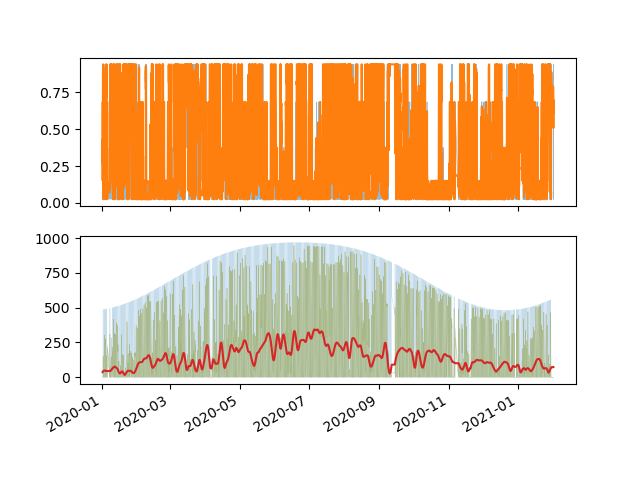

In [70]:
fig,axs=plt.subplots(2,1,sharex=True)

axs[0].plot(df.time, df.cloudiness, lw=0.5, alpha=0.5)
axs[0].plot(df.time, df.cloudiness_lp)
axs[1].plot(df.time, df.sol_rad, alpha=0.3,lw=0.3)
axs[1].plot(df.time, df.sol_rad_cloud, alpha=0.3,lw=0.3)
axs[1].plot(df.time, df.sol_rad_cloud, alpha=0.3,lw=0.3)
axs[1].plot(df.time, df.sol_rad_cloud_lp)

fig.autofmt_xdate()

In [64]:
df.time.values

array(['2020-01-01T08:00:00.000000000', '2020-01-01T08:05:00.000000000',
       '2020-01-01T08:10:00.000000000', ...,
       '2021-02-01T07:45:00.000000000', '2021-02-01T07:50:00.000000000',
       '2021-02-01T07:55:00.000000000'], dtype='datetime64[ns]')